In [159]:
#PARAMETERS - User input.
#Program assumes Mira photometry CSV and that image is 4096x4096.

target = 'M3'

rawMira = './VariableStarExtras/M3_2nights_rawPhotometry.csv'
directory = 'C:/Users/ronald.sumners/Desktop/VariableStarAnalysis'
rawFit = directory + '/M3_a60-026_bdn_r1_r2_may29_r3_r4.fit'
croppedFitOutput = "C:/Users/ronald.sumners/Desktop/CroppedFits/M3_WCS_Crop_"
parametersOutput = 'StarParameters.csv'

AstrometryNet.key = 'cibwfruamvhkzmdd'

nonVariableThreshold = 0.2
uncertainThreshold = 4 #The resolution of the BN is 3.8"/px
unclassifiedThreshold = 15
numStars = 220

In [160]:
#Import all libraries.
import pandas as pd
import math
from astropy.io import fits
import os
from astropy.wcs import WCS
import numpy as np
import keyring
from astroquery.astrometry_net import AstrometryNet
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [161]:
#Import the raw star photometry data from Mira CSV
starData = pd.read_csv(rawMira)
starData.columns = starData.columns.str.replace(' ', '')
starData = starData.set_index('#')

In [162]:
#Create star parameters dataframe. Get locations and names of stars.
x = []
y = []
starName = []
    
for i in range(1, numStars + 1):
    name1 = target + '-' + str(i)
    starName.append(name1)

    x.append(starData['X'][starData['Name'] == name1].reset_index(drop=True)[0])
    y.append(starData['Y'][starData['Name'] == name1].reset_index(drop=True)[0])
    
starParams = pd.DataFrame(data={'x': x, 'y': y}, index=starName)

In [163]:
#Split the 4096x4096 photometry image into 16 different sections.

data, header = fits.getdata(rawFit, header = True)

for i in range(4):
    for j in range(4):
        hdu = fits.PrimaryHDU(data[1024*i:1024*(i+1), 1024*j:1024*(j+1)])
        hdu.writeto(croppedFitOutput + f"{4*i + j}.fits", overwrite = True)

x = starParams['x']
y = starParams['y']

quad = []
for i in range(numStars):
    quadrant_x = x[i]//1024
    quadrant_y = y[i]//1024
    quad.append(quadrant_x + 4*quadrant_y)

starParams['Quadrant'] = quad

In [164]:
#Run those split images through Astrometry to get WCS headers. 
#Use those headers to find the real sky coordinates of each star.

w = []
for i in range(16):
    print(f'\nQuadrant {i}')
    wcs_header = AstrometryNet.solve_from_image(croppedFitOutput + f'{i}.fits', detect_threshold = 3)
    w.append(wcs_header)
    
Ra = []
Dec = []
for i in range(1, numStars + 1):
    quadrant = starParams['Quadrant'][i-1]
    wc = WCS(w[int(quadrant)])
    sky = wc.pixel_to_world_values(starParams.iloc[i-1, 0]-1024*(starParams.iloc[i-1, 0]//1024), starParams.iloc[i-1, 1]-1024*(starParams.iloc[i-1, 1]//1024))

    Ra.append(sky[0].item())
    Dec.append(sky[1].item())

starParams['RA'] = Ra
starParams['Dec'] = Dec


Quadrant 0
Solving...........
Quadrant 1
Solving................
Quadrant 2
Solving....................
Quadrant 3
Solving...............
Quadrant 4
Solving...........
Quadrant 5
Solving..........
Quadrant 6
Solving..........
Quadrant 7
Solving...........
Quadrant 8
Solving...............
Quadrant 9
Solving.....
Quadrant 10
Solving...............
Quadrant 11
Solving................
Quadrant 12
Solving.......
Quadrant 13
Solving...........
Quadrant 14
Solving.........
Quadrant 15
Solving.................................................

In [165]:
#Gets the magnitudes and magnitude errors of each star over time from the raw Mira CSV. Useful for differential photometry.
magnitude_dict = {}
errors_dict = {}
for i in range(1, numStars + 1):
    name = target + '-' + str(i)
    magnitude_dict[name] = starData['Mag'][starData['Name'] == name].reset_index(drop=True)
    errors_dict[name] = starData['Error(T)'][starData['Name'] == name].reset_index(drop=True)

starMagnitudes = pd.DataFrame(magnitude_dict)
starErrors = pd.DataFrame(errors_dict)

In [166]:
#Look up what type of object each star is with Simbad (based on real coordinates found earlier).
#If object is within 2 arcseconds of another, list type as uncertain. If more than 15 arcseconds, it is not catalogued.
starTypeList = []

custom_simbad = Simbad()
custom_simbad.add_votable_fields('otype')
custom_simbad.add_votable_fields('distance_result')

for i in range(numStars):
    coord1 = starParams['RA'].iloc[i]
    coord2 = starParams['Dec'].iloc[i]

    c = SkyCoord(coord1, coord2, frame='icrs', unit='deg')
    transformed_c = c.to_string('hmsdms')

    r = 2 * u.arcminute

    result_table = custom_simbad.query_region(c, radius=r)

    starType = result_table['OTYPE'][0]
    starTypeList.append(starType)
    try:
        if (result_table['DISTANCE_RESULT'][1]-result_table['DISTANCE_RESULT'][0]) < uncertainThreshold:
            starTypeList[-1] = 'UNCERTAIN'
        if (result_table['DISTANCE_RESULT'][0]) > unclassifiedThreshold:
            starTypeList[-1] = 'UNCLASSIFIED'
    except:
        continue

starParams['Type'] = starTypeList

In [167]:
#Confirm which stars are already classified variable stars. Remove them from the analysis.
#Make special note of which stars uncertain or unclassified.
#Uncertain stars MAY BE variables. Manual lookup needed.
#For the rest of the stars, use those who have variations less than x for differential photometry.

variables = starParams.index[(starParams['Type'] == 'RRLyrae') | (starParams['Type'] == 'EclBin')].tolist()
uncertain = starParams.index[(starParams['Type'] == 'UNCERTAIN') | (starParams['Type'] == 'UNCLASSIFIED')].tolist()

nonVariables = []
for i in range(numStars):
    if starMagnitudes.iloc[:, i].max()-starMagnitudes.iloc[:, i].min() < nonVariableThreshold and f'{target}-{i+1}' not in variables:
        nonVariables.append(f'{target}-{i+1}')
    
print(f'CONFIRMED VARAIBLE STARS: \n{variables}\n')
print(f'UNCERTAIN OR UNCLASSIFIED STARS: \n{uncertain}\n')
print(f'NON VARIABLE COMPARISON STARS: \n{nonVariables}\n')

CONFIRMED VARAIBLE STARS: 
['M3-1', 'M3-2', 'M3-3', 'M3-4', 'M3-5', 'M3-10', 'M3-11', 'M3-15', 'M3-16', 'M3-23', 'M3-61', 'M3-75', 'M3-88', 'M3-102', 'M3-110', 'M3-217']

UNCERTAIN OR UNCLASSIFIED STARS: 
['M3-8', 'M3-14', 'M3-17', 'M3-24', 'M3-25', 'M3-32', 'M3-38', 'M3-40', 'M3-42', 'M3-47', 'M3-49', 'M3-50', 'M3-51', 'M3-52', 'M3-53', 'M3-55', 'M3-56', 'M3-69', 'M3-79', 'M3-89', 'M3-116', 'M3-125', 'M3-136', 'M3-153', 'M3-170', 'M3-188', 'M3-189', 'M3-206', 'M3-211']

NON VARIABLE COMPARISON STARS: 
['M3-50', 'M3-53', 'M3-131', 'M3-152', 'M3-154', 'M3-171', 'M3-178']



In [168]:
#Calculates the difference in magnitude between star and the non variables found earlier.
#Output star parameters to CSV.

differential_magnitude_dict = {}

for j in range(0, numStars):
    totalDifferentials = pd.DataFrame({})
    for k in range(len(nonVariables)):
        name = target + '-' + str(j+1)
        name2 = nonVariables[k]
        differential = starMagnitudes[name] - starMagnitudes[name2]
        
        totalDifferentials = pd.concat([totalDifferentials, differential.rename(str(k+1))], axis=1)
    
    differential_magnitude_dict[target + '-' + str(j+1) + ' Differential'] = totalDifferentials.mean(axis=1)


differentialMagnitudes = pd.DataFrame(differential_magnitude_dict)

starParams.to_csv(parametersOutput, index=True)

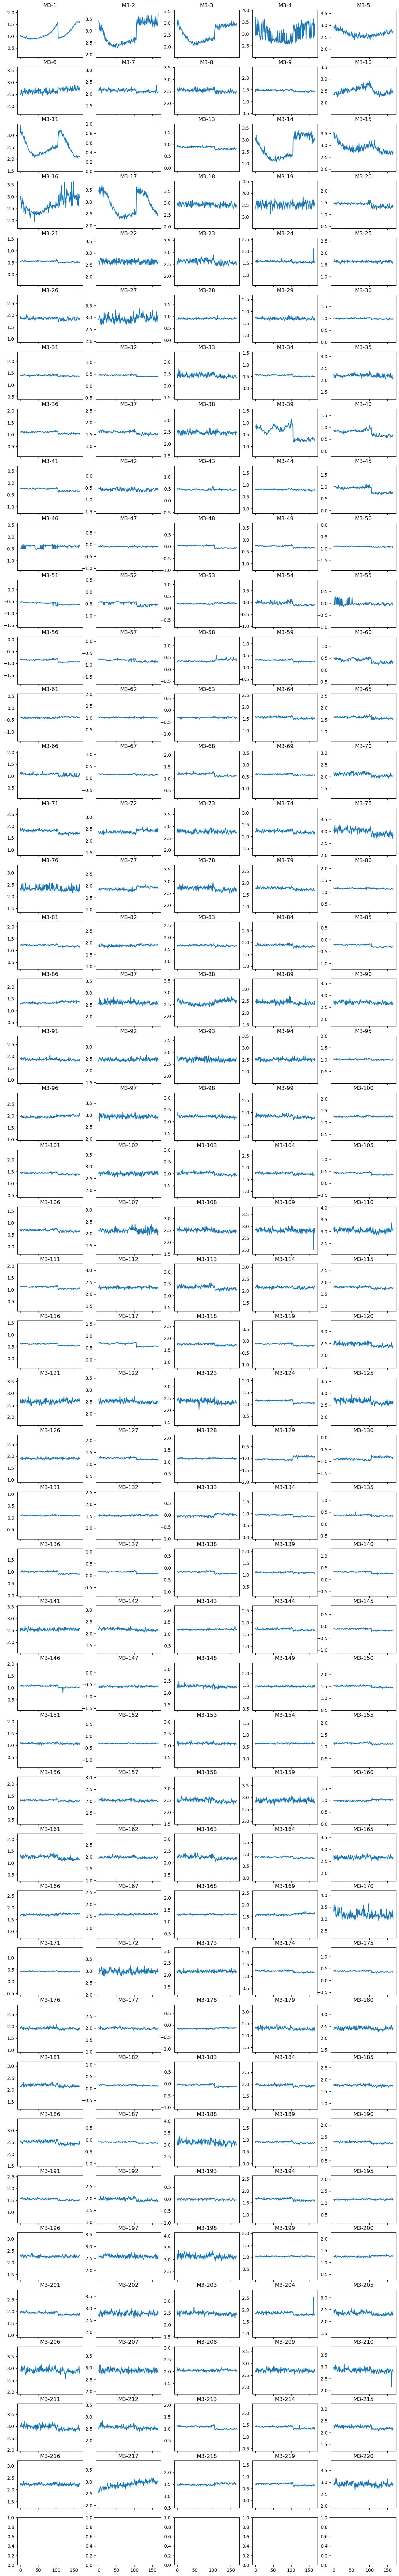

In [169]:
#Plot differential photometry of all stars.

offset = 0
fig, axs = plt.subplots(numStars//5+1, 5, sharex = True, sharey = False, figsize = (15, (len(differentialMagnitudes)//5+1) * 3))
flagVariable = []
variabilityThreshold = 0.25

for i in range(numStars//5+1):
    if i >= numStars:
        break
    for j in range(5):
        x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))
        try:
            mags_smooth = savgol_filter(differentialMagnitudes.iloc[:, 5*i + j + offset].to_numpy(), 20, 2)
            if mags_smooth.max() - mags_smooth.min() > variabilityThreshold and f'{target}-{5*i+j+offset+1}' not in variables:
                flagVariable.append(f'{target}-{5*i+j+offset+1}')
                
            axs[i, j].plot(x, differentialMagnitudes.iloc[:, 5*i + j + offset])
            axs[i, j].fill_between(x, 
                                   differentialMagnitudes.iloc[:, 5*i + j + offset] - starErrors[f'{target}-{5*i+j+1}'],
                                   differentialMagnitudes.iloc[:, 5*i + j + offset] + starErrors[f'{target}-{5*i+j+1}'],
                                   alpha=0.2, color='#26a8ff')
            axs[i, j].set_title(target + '-' + str(5*i+j + 1))
            axs[i, j].set_ylim(differentialMagnitudes.iloc[:, 5*i + j + offset].mean()-1, differentialMagnitudes.iloc[:, 5*i + j + offset].mean()+1)
        except:
            continue

plt.show()

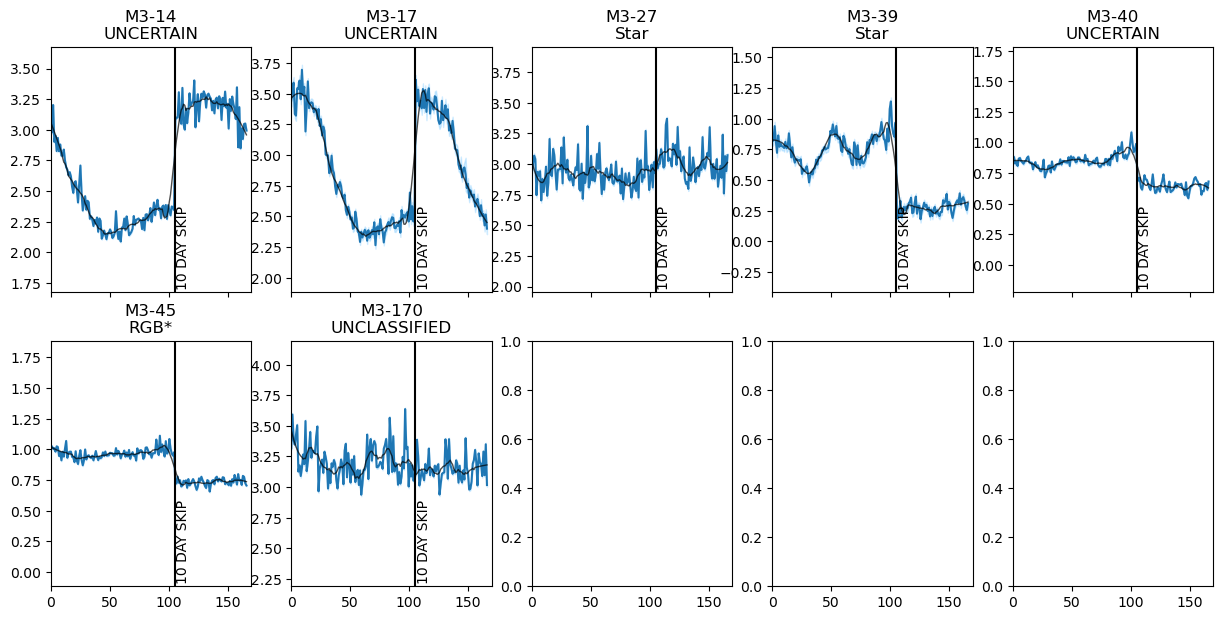

In [170]:
#Plot differential photometry of possible new variables.

fig, axs = plt.subplots(len(flagVariable)//5 + 1, 5, sharex = True, sharey = False, figsize = (15, len(flagVariable)//5*7))

i = 0
j = 0
count = 0
x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))
for star in flagVariable:
    j = count % 5
    i = count //5
    
    starNumber = int(star.replace(target + '-', ''))
    axs[i, j].plot(x, differentialMagnitudes.iloc[:, starNumber-1])
    axs[i, j].fill_between(x, 
               differentialMagnitudes.iloc[:,starNumber-1] - starErrors[f'{target}-{starNumber-1}'],
               differentialMagnitudes.iloc[:,starNumber-1] + starErrors[f'{target}-{starNumber-1}'],
               alpha=0.2, color='#26a8ff')
    smoothed = savgol_filter(differentialMagnitudes.iloc[:, starNumber-1].to_numpy(), 20, 2)
    axs[i, j].plot(x, smoothed, 'black', alpha=0.7, linewidth=1)
    axs[i, j].axvline(x=105, color='black')
    axs[i, j].text(106.5, differentialMagnitudes.iloc[:, starNumber-1].mean() - 0.95, '10 DAY SKIP', rotation=90)
    axs[i, j].set_title(f'{target}-{starNumber}\n{starParams["Type"].iloc[starNumber-1]}')
    axs[i, j].set_ylim(differentialMagnitudes.iloc[:, starNumber-1].mean()-1, differentialMagnitudes.iloc[:, starNumber-1].mean()+1)
    axs[i, j].set_xlim(0, 170)
    count += 1

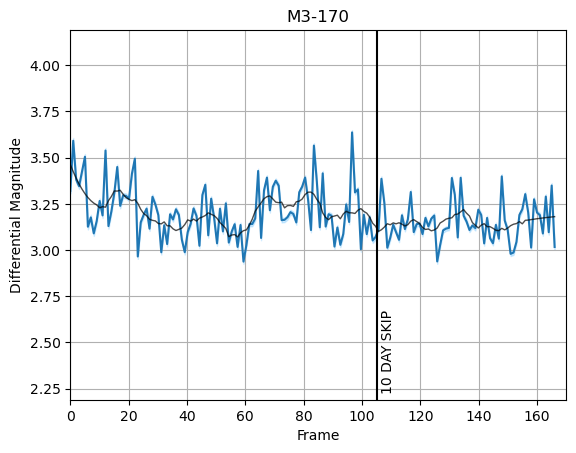

In [172]:
#Plot differential photometry of individual star for further investigation.

star = 170

plt.plot(x, differentialMagnitudes.iloc[:, star-1])
plt.fill_between(x, 
               differentialMagnitudes.iloc[:,star-1] - starErrors[f'{target}-{star-1}'],
               differentialMagnitudes.iloc[:,star-1] + starErrors[f'{target}-{star-1}'],
               alpha=0.2, color='#26a8ff')

try:
    smoothed = savgol_filter(differentialMagnitudes.iloc[:, star-1].to_numpy(), 20, 2)
    plt.plot(x, smoothed, 'black', alpha=0.7, linewidth=1)
except:
    pass

plt.axvline(x=105, color='black')
plt.text(106.5, differentialMagnitudes.iloc[:, star-1].mean() - 0.95, '10 DAY SKIP', rotation=90)
plt.grid()
plt.title(f'{target}-{star}')
plt.ylim(differentialMagnitudes.iloc[:, star-1].mean()-1, differentialMagnitudes.iloc[:, star-1].mean()+1)
plt.xlim(0, 170)
plt.xlabel('Frame')
plt.ylabel('Differential Magnitude')
plt.show()

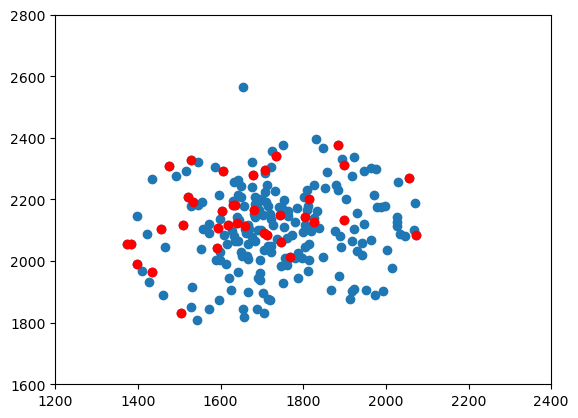

In [183]:
starList = [13, 20, 31, 32, 34, 36, 37, 41, 48, 49, 56, 59, 85, 129, 130, 133, 134, 95, 105, 106, 111, 116, 117, 119, 124, 127, 136, 137, 138, 140, 145, 183, 194, 201, 213, 214, 219]

plt.scatter(starParams['x'], starParams['y'])
for star in starList:
    plt.scatter(starParams['x'].iloc[star-1], starParams['y'].iloc[star-1], color='r')
plt.xlim(1200, 2400)
plt.ylim(1600, 2800)
plt.show()